In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path

model_path = '/content/drive/MyDrive/model_result'

def check_save_folder(input_path: Path) -> None:
    input_path.resolve().mkdir(parents=True, exist_ok=True)
    print(f'確認存檔路徑: {input_path.resolve()}')

check_save_folder(Path(model_path))

確認存檔路徑: /content/drive/MyDrive/model_result


# 安裝 pip install scikit-plot


In [3]:
!pip install scikit-plot

# 建立 transform

In [4]:
import torchvision.transforms as transforms

training_transfrom = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomResizedCrop((256, 256), 
                              scale=(0.92, 1.0),
                              ratio=(1.0, 1.0), 
                              interpolation=transforms.InterpolationMode.NEAREST),
  transforms.RandomPerspective(distortion_scale=0.2, p=0.5, 
                              interpolation=transforms.InterpolationMode.NEAREST),
  transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.NEAREST),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.ColorJitter(brightness=0.2, contrast=0.5),
  
])

valid_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256))])

# 讀取資料集

In [5]:
from torchvision.datasets import ImageFolder


img_dataset = ImageFolder(root='/content/drive/MyDrive/lesson_dataset',
                          transform=training_transfrom
                          )

# 拆分資料集 
- 訓練集, 驗證集, 測試集


In [6]:
import torch
from torch.utils.data import random_split
from typing import Tuple
import copy

def get_data_group_number(data_number: int,
                          train_set_ratio: float = 0.6) -> Tuple[int, int, int]:
    valid_size = int(data_number * ((1 - train_set_ratio) / 2))
    test_size = valid_size
    train_size = data_number - valid_size - test_size
    print(f'train_size:{train_size}, '
          f'valid_size:{valid_size}, '
          f'test_size:{test_size}')
    return train_size, valid_size, test_size


train_size, valid_size, test_size = get_data_group_number(len(img_dataset), 0.6)

train_dataset, valid_dataset, test_dataset = random_split(img_dataset, 
                                                          [train_size, valid_size, test_size],
                                                          torch.Generator().manual_seed(42)
                                                          )

original_train_dataset = copy.deepcopy(train_dataset)

valid_dataset.dataset.transform = valid_transform
test_dataset.dataset.transform = valid_transform

print(valid_dataset.dataset.transform)

train_size:60, valid_size:20, test_size:20
Compose(
    ToTensor()
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
)


In [7]:
print(f'替換 transform 後\n{train_dataset.dataset.transform}\n')

print(f'原始 transform \n{original_train_dataset.dataset.transform}')

替換 transform 後
Compose(
    ToTensor()
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
)

原始 transform 
Compose(
    ToTensor()
    RandomResizedCrop(size=(256, 256), scale=(0.92, 1.0), ratio=(1.0, 1.0), interpolation=nearest)
    RandomPerspective(p=0.5)
    RandomRotation(degrees=[-20.0, 20.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ColorJitter(brightness=[0.8, 1.2], contrast=[0.5, 1.5], saturation=None, hue=None)
)


## 統計各資料組別的樣本數量

In [8]:
from torch.utils.data.dataset import Subset

def count_class_in_set(input_dataset: Subset) -> Tuple[dict, dict]:
    """

    :param input_dataset:  傳入已經透過 Subset 分割好的資料
    target_folder_as_class 將會透過圖片的上層資料夾名稱作為圖片類別，統計使用數量
    資料夾目錄結構
      root-
            -A
                -num1
                    -.png
                    -.png
            -B
                -num2
                    -.png
    target_folder_as_class = ['num1','num1','num2']

    :return: 1.透過圖片上層 [num1,num2] 資料夾統計 num1 跟 num2 個別圖片使用數量,
             2.透過 root 內的 [A,B] 資料夾統計 A 跟 B 個別使用圖片數量
    """

    target_folder_as_class = [Path(input_dataset.dataset.imgs[index][0]).parent.name for index in input_dataset.indices]
    target_class_name = sorted(list(set(target_folder_as_class)))
    pic_class_num_dict = {}
    for cls_name in target_class_name:
        pic_class_num_dict[cls_name] = target_folder_as_class.count(cls_name)

    data_class_label = [input_dataset.dataset.targets[index] for index in input_dataset.indices]
    class_label_name = list(set(data_class_label))
    class_label_num_dict = {}

    for label_name in class_label_name:
        class_label_num_dict[label_name] = data_class_label.count(label_name)

    return pic_class_num_dict, class_label_num_dict

print(count_class_in_set(train_dataset))
print(count_class_in_set(valid_dataset))
print(count_class_in_set(test_dataset))

({'monitor': 24, 'mouse': 19, 'mug': 17}, {0: 24, 1: 19, 2: 17})
({'monitor': 9, 'mouse': 6, 'mug': 5}, {0: 9, 1: 6, 2: 5})
({'monitor': 10, 'mouse': 5, 'mug': 5}, {0: 10, 1: 5, 2: 5})


# 建立資料DataLoader

In [9]:
from torch.utils.data import DataLoader

batch_size = 4

trainset_loader = DataLoader(
      dataset=original_train_dataset,
      num_workers=2,
      batch_size=batch_size,
      shuffle=True
    )

validset_loader = DataLoader(
      dataset=valid_dataset,
      num_workers=2,
      batch_size=batch_size,
      shuffle=True
    )

testset_loader = DataLoader(
      dataset=test_dataset,
      num_workers=2,
      batch_size=batch_size,
      shuffle=True
    )

# 建立硬體檢查

In [10]:
def device_setter() -> torch.device:
    return torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

device_setter()

device(type='cpu')

# 建立模型, Resnet18

In [ ]:
from torchvision.models import resnet
import torch.nn as nn

num_classes = 3

# model = resnet.resnet18(num_classes=num_classes)
model = resnet.resnet18(pretrained=True).to(device = device_setter())
model.fc = nn.Linear(model.fc.in_features, num_classes)

print(model)

# 建立訓練流程


In [12]:
def train(trainset_loader, 
          validset_loader, 
          testset_loader, 
          model, 
          criterion, 
          optimizer, 
          learning_rate, 
          epoch: int, 
          device: torch.device,
          max_avg_f1_score: float,
          model_path: str):
  
  model.train()

  for training_epoch in range(epoch):

      running_loss = 0.0
      total_img_num = 0

      for iteration_num, (input_data, data_label) in enumerate(trainset_loader):
          
          total_img_num += input_data.size(0)

          input_data, data_label = input_data.to(device), data_label.to(device)

          
          with torch.set_grad_enabled(True):

              optimizer.zero_grad()

              outputs = model(input_data)

              loss = criterion(outputs, data_label)

              loss.backward()

              optimizer.step()

          running_loss += loss.item() * input_data.size(0)

      learning_rate.step()


      report, cm_result, auc_result, avg_f1_score, eval_loss = eval_model(validset_loader, model, criterion, device)
      
      print(f'epoch: {training_epoch + 1}/{epoch}', 
        f'learning_rate: {learning_rate.get_last_lr()}, '
        f'train loss: {running_loss / total_img_num:.4f}, '
        f'eval loss: {eval_loss:.4f}')

      if avg_f1_score >= max_avg_f1_score:
          max_avg_f1_score = avg_f1_score

          save_model(model = model,
                    max_avg_f1_score = max_avg_f1_score,
                    save_path = f'{model_path}/model_weight_best.pkl')
          
      save_model(model = model,
                  max_avg_f1_score = max_avg_f1_score,
                  save_path = f'{model_path}/model_weight.pkl')    
      
      

      
      

# 建立驗證流程

In [36]:
def eval_model(data_loader, model, criterion, device: torch.device):
    model.eval()
    predict_np = None
    true_label_np = None
    predict_prob_np = None
    total_img_num = 0
    running_loss = 0.0

    for iteration_num, (input_data, data_label) in enumerate(data_loader):

        total_img_num += input_data.size(0)

        input_data, data_label = input_data.to(device), data_label.to(device)
        

        with torch.set_grad_enabled(False):

            outputs = model(input_data)

            predict_prob_to_cpu = torch.softmax(outputs.detach().cpu(), dim=1)

            max_prob_value, predict_cls = torch.max(predict_prob_to_cpu, 1)
            print(predict_prob_to_cpu)
            print(data_label)
            print(max_prob_value)
            print(predict_cls)

            predict_cls_serial = predict_cls.cpu().reshape(-1)

            true_cls_serial = data_label.cpu().squeeze().reshape(-1)

            loss = criterion(outputs, data_label)

            running_loss += loss.item() * input_data.size(0)

        if predict_np is None:

            predict_np = predict_cls_serial
            true_label_np = true_cls_serial
            predict_prob_np = predict_prob_to_cpu

        else:
            predict_np = np.concatenate((predict_np, predict_cls_serial), axis=0)
            true_label_np = np.concatenate((true_label_np, true_cls_serial), axis=0)
            predict_prob_np = np.concatenate((predict_prob_np, predict_prob_to_cpu), axis=0)

    report, report_dict, cm_result = confusion_metrics(y_true=true_label_np, y_pred=predict_np,
                                      target_names=data_loader.dataset.dataset.classes,
                                      digits=4,
                                      output_dict=True,
                                      labels=np.unique(true_label_np))
    
    average_f1_score = report_dict['macro avg']['f1-score']

    auc_result = calculate_auc(y_true=true_label_np,
                               predict_prob=predict_prob_np)
    
    
    print(f'Metrics\n{report}\n',
          f'Confusion matrix\n{cm_result}\n',
          f'Average auroc: {auc_result}\n',
          f'Average f1-score: {average_f1_score}\n')
    
    plot_confusion_matrix(cm_result)

    import scikitplot as skplt
    skplt.metrics.plot_roc(y_true=true_label_np, 
                y_probas=predict_prob_np, 
                plot_micro=True, 
                plot_macro=True)
    skplt.metrics.plot_precision_recall(y_true=true_label_np, 
                y_probas=predict_prob_np)

    eval_loss = running_loss / total_img_num

    return report, cm_result, auc_result, average_f1_score, eval_loss


# 透過 sklearn.metrics 衡量模型效能

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

## 混淆矩陣


In [15]:
def calculate_auc(y_true: np.ndarray, predict_prob: np.ndarray):
    if len(np.unique(y_true)) > 2:
        return multi_classification(y_true=y_true, predict_prob=predict_prob)

    return sklearn_auc(y_true=y_true, predict_prob=predict_prob)
    
def confusion_metrics(y_true: np.ndarray,
                      y_pred: np.ndarray,
                      target_names: list,
                      digits: int = 2,
                      output_dict: bool = False,
                      labels: np.ndarray = None,
                      zero_division=0) -> Tuple[dict, np.ndarray]:

    report = classification_report(y_true=y_true, y_pred=y_pred,
                                   target_names=target_names,
                                   digits=digits,
                                   output_dict=False,
                                   labels=np.unique(labels),
                                   zero_division=zero_division,
                                   )
    report_dict = classification_report(y_true=y_true, y_pred=y_pred,
                                   target_names=target_names,
                                   digits=digits,
                                   output_dict=output_dict,
                                   labels=np.unique(labels),
                                   zero_division=zero_division,
                                   )
    
    cm_result = confusion_matrix(y_true=y_true,
                                 y_pred=y_pred,
                                 labels=np.unique(labels))
    return report, report_dict, cm_result

## AUC

In [16]:
def sklearn_auc(y_true: np.ndarray, predict_prob: np.ndarray) -> float:
    fpr, tpr, threshold = roc_curve(y_true, predict_prob)
    return auc(fpr, tpr)

def multi_classification(y_true: np.ndarray,
                         predict_prob: np.ndarray):
    """
    roc 只支援兩類計算, 所以需要對輸入進行 binarize 轉換

    numpy 說明
    a = [[0,1,5],
         [1,2,3]]
    a[:,1] = [1,2]

    若目前是3類, 則輸出會如以下形式
        binarize 前類別如下:
            [0,1,2]
        binarize 後:
            [[1,0,0],[0,1,0],[0,0,1]]
    """
    class_list = np.unique(y_true)
    from sklearn.preprocessing import label_binarize
    y_true_after_binarize = label_binarize(y_true, classes=class_list)

    total_auc = 0
    for class_index in class_list:
        auc_result = sklearn_auc(y_true=y_true_after_binarize[:, class_index],
                                 predict_prob=predict_prob[:, class_index])
        print(f'{class_index} auc_roc: {auc_result:.5f}')
        total_auc += auc_result
    return total_auc / len(class_list)

## 建立繪製混淆矩陣函式

In [17]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm_matrix: np.ndarray):

    thresh = cm_matrix.max() / 2

    plt.matshow(cm_matrix)

    for axis_0 in range(cm_matrix.shape[0]):

        for axis_1 in range(cm_matrix.shape[1]):

            if cm_matrix[axis_0, axis_1] > 0:

                plt.text(x=axis_1, y=axis_0, s=cm_matrix[axis_0, axis_1],
                         horizontalalignment="center",
                         verticalalignment='center',
                         color="white" if cm_matrix[axis_0, axis_1] < thresh else "black",
                         fontsize=45)

    plt.show()

# 模型存檔

In [18]:
def save_model(model, max_avg_f1_score, save_path: str):
    torch.save({"model_state": model.state_dict(),
                "max_avg_f1_score": max_avg_f1_score
                },
               save_path)

    if 'best' in save_path:
        print("儲存最佳 f1_score 權重...")
        return
    print("儲存權重...")

## 模型讀檔

In [19]:
def load_model(model, model_path: str, device: torch.device):

    max_avg_f1_score = 0.0
    
    if Path(model_path).is_file():
        
        if device == 'cpu':
            model_dict = torch.load(model_path, map_location=torch.device('cpu'))
        else:
            model_dict = torch.load(model_path, map_location=torch.device(device))
        try:
            model.load_state_dict(model_dict.get('model_state'))
            max_avg_f1_score = float(model_dict.get('max_avg_f1_score'))
        except Exception as e:
            print(f'Error Message:{e}')
            model.load_state_dict(model_dict.state_dict())

    model.to(device = device)
    return model, max_avg_f1_score

# 建立模型訓練用函數
- 損失函數
- 優化器
- 學習率


In [20]:
from torch.optim import lr_scheduler, Adam

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001, )
learning_rate = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)

print(criterion)
print(optimizer)
print(learning_rate.get_last_lr())

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0
)
[0.0001]


# 開始訓練

In [ ]:
model, max_avg_f1_score = load_model(model, model_path = f'{model_path}/model_weight.pkl', device = device_setter())

epoch = 1

train(trainset_loader = trainset_loader, 
      validset_loader = validset_loader, 
      testset_loader = testset_loader, 
      model = model, 
      criterion = criterion, 
      optimizer = optimizer, 
      learning_rate = learning_rate, 
      epoch = epoch, 
      device = device_setter(),
      max_avg_f1_score = max_avg_f1_score,
      model_path = model_path
      )

tensor([[0.2013, 0.3251, 0.4737],
        [0.1747, 0.2943, 0.5311],
        [0.1264, 0.5332, 0.3404],
        [0.3187, 0.3600, 0.3213]])
tensor([1, 1, 2, 0])
tensor([0.4737, 0.5311, 0.5332, 0.3600])
tensor([2, 2, 1, 1])
tensor([[0.2226, 0.2546, 0.5228],
        [0.1588, 0.4172, 0.4239],
        [0.4381, 0.2760, 0.2859],
        [0.3563, 0.4002, 0.2435]])
tensor([1, 1, 0, 0])
tensor([0.5228, 0.4239, 0.4381, 0.4002])
tensor([2, 2, 0, 1])
tensor([[0.2004, 0.4716, 0.3281],
        [0.4307, 0.2855, 0.2838],
        [0.5764, 0.1536, 0.2699],
        [0.5048, 0.2256, 0.2697]])
tensor([2, 0, 0, 0])
tensor([0.4716, 0.4307, 0.5764, 0.5048])
tensor([1, 0, 0, 0])
tensor([[0.2957, 0.2841, 0.4201],
        [0.1993, 0.3988, 0.4019],
        [0.1314, 0.5097, 0.3589],
        [0.4233, 0.3193, 0.2574]])
tensor([1, 2, 2, 0])
tensor([0.4201, 0.4019, 0.5097, 0.4233])
tensor([2, 2, 1, 0])
tensor([[0.3931, 0.3344, 0.2726],
        [0.1454, 0.5401, 0.3145],
        [0.1487, 0.2805, 0.5708],
        [0.5994, 0

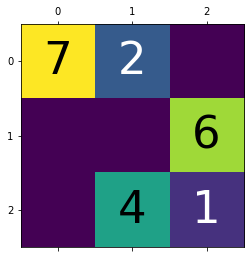

('              precision    recall  f1-score   support\n\n     monitor     1.0000    0.7778    0.8750         9\n       mouse     0.0000    0.0000    0.0000         6\n         mug     0.1429    0.2000    0.1667         5\n\n    accuracy                         0.4000        20\n   macro avg     0.3810    0.3259    0.3472        20\nweighted avg     0.4857    0.4000    0.4354        20\n',
 array([[7, 2, 0],
        [0, 0, 6],
        [0, 4, 1]]),
 0.6558730158730158,
 0.34722222222222227,
 0.9893389463424682)

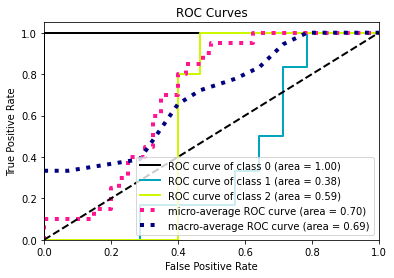

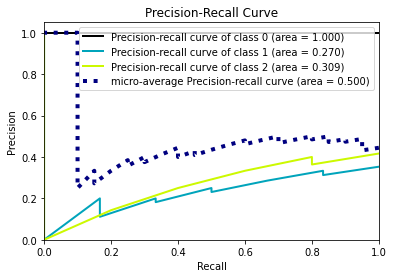

In [37]:
eval_model(validset_loader, model, criterion, device_setter())

# 查看 heatmap

In [23]:
def get_heatmap(model: nn.Module, input_img: torch.Tensor) -> torch.Tensor:
  get_model_before_linear_layer = nn.Sequential(*list(model.children())[:-2])
  return get_model_before_linear_layer(input_img)

In [24]:
import PIL.Image as PILImage

pil_img = PILImage.open('/content/drive/MyDrive/lesson_dataset/monitor/frame_0001.jpg')
tensor_img = transforms.ToTensor()(pil_img)
tensor_img_with_batch_shape = tensor_img.unsqueeze(0)


## 訓練過的模型

(1, 17, 17, 512)


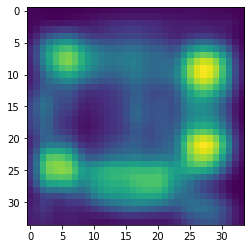

In [31]:
hm_img = get_heatmap(model = model, input_img = tensor_img_with_batch_shape)

import scipy.ndimage

hm_img = hm_img.detach().numpy().transpose(0, 2, 3, 1)
print(hm_img.shape)

hm_zoom_in = scipy.ndimage.zoom(hm_img, 2, order=2)
plt.imshow(np.sum(hm_zoom_in[0], axis=2))

## 未經訓練的模型

(1, 17, 17, 512)


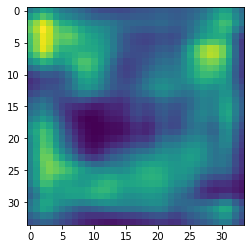

In [28]:
original_model = resnet.resnet18(pretrained=True).to(device = device_setter())
model.fc = nn.Linear(original_model.fc.in_features, 3)

hm_img = get_heatmap(model = original_model, input_img = tensor_img_with_batch_shape)

hm_img = hm_img.detach().numpy().transpose(0, 2, 3, 1)
print(hm_img.shape)

hm_zoom_in = scipy.ndimage.zoom(hm_img, 2, order=2)
plt.imshow(np.sum(hm_zoom_in[0], axis=2))